In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from models import SimpleClassifier
import time

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# ----------- Data Loading -----------
train_data = np.load("bert_embeddings_train.npz")
test_data = np.load("bert_embeddings_test.npz")
buckets = np.load("difficulty_buckets.npz")

X_train = torch.tensor(train_data["embeddings"], dtype=torch.float32)
y_train = torch.tensor(train_data["labels"], dtype=torch.long)
X_test = torch.tensor(test_data["embeddings"], dtype=torch.float32)
y_test = torch.tensor(test_data["labels"], dtype=torch.long)

X_easy = torch.tensor(buckets["easy_embeddings"], dtype=torch.float32)
y_easy = torch.tensor(buckets["easy_labels"], dtype=torch.long)
X_medium = torch.tensor(buckets["medium_embeddings"], dtype=torch.float32)
y_medium = torch.tensor(buckets["medium_labels"], dtype=torch.long)
X_hard = torch.tensor(buckets["hard_embeddings"], dtype=torch.float32)
y_hard = torch.tensor(buckets["hard_labels"], dtype=torch.long)

# Random bucketing
perm = torch.randperm(len(X_train))
X_shuffled = X_train[perm]
y_shuffled = y_train[perm]

# Split into 3 equal random buckets
n = len(X_shuffled) // 3
X_rand_easy, y_rand_easy   = X_shuffled[:n], y_shuffled[:n]
X_rand_medium, y_rand_medium = X_shuffled[n:2*n], y_shuffled[n:2*n]
X_rand_hard, y_rand_hard   = X_shuffled[2*n:], y_shuffled[2*n:]

In [3]:
# ----------- Utility Functions -----------
def train(model, optimizer, X, y, epochs=3, batch_size=32):
    model.train()
    losses, accs = [], []
    loader = DataLoader(TensorDataset(X, y), batch_size=batch_size, shuffle=True)
    for _ in range(epochs):
        correct, total_loss, total = 0, 0, 0
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = F.cross_entropy(out, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            preds = out.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
        losses.append(total_loss / len(loader))
        accs.append(correct / total)
    return losses, accs

def evaluate(model, X, y):
    model.eval()
    with torch.no_grad():
        preds = model(X.to(device)).argmax(dim=1)
        return (preds == y.to(device)).float().mean().item()

def predict(model, X):
    model.eval()
    with torch.no_grad():
        return model(X.to(device)).argmax(dim=1).cpu().numpy()


In [59]:
# ----------- Vanilla Training -----------
start_time = time.time()
vanilla_model = SimpleClassifier().to(device)
vanilla_opt = torch.optim.Adam(vanilla_model.parameters(), lr=1e-4)
v_loss, v_acc = train(vanilla_model, vanilla_opt, X_train, y_train, epochs=150)
vanilla_train_time = time.time() - start_time

In [60]:
# ----------- Random Buckets Training -----------
start_time = time.time()
random_model = SimpleClassifier().to(device)
random_opt = torch.optim.Adam(random_model.parameters(), lr=1e-4)

r_loss, r_acc = [], []

for cycle in range(15):
    print(f"Cycle {cycle+1}: Training on 'Easy' (random)...")
    l, a = train(random_model, random_opt, X_rand_easy, y_rand_easy, epochs=3)
    r_loss += l
    r_acc += a

    print(f"Cycle {cycle+1}: Training on 'Medium' (random)...")
    l, a = train(random_model, random_opt, X_rand_medium, y_rand_medium, epochs=3)
    r_loss += l
    r_acc += a

    print(f"Cycle {cycle+1}: Training on 'Hard' (random)...")
    l, a = train(random_model, random_opt, X_rand_hard, y_rand_hard, epochs=3)
    r_loss += l
    r_acc += a

# for cycle in range(3):
#     print(f"Cycle {cycle+1}: Training on 'Easy' (random)...")
#     l, a = train(random_model, random_opt, X_rand_easy, y_rand_easy, epochs=20)
#     r_loss += l
#     r_acc += a

#     print(f"Cycle {cycle+1}: Training on 'Medium' (random)...")
#     l, a = train(random_model, random_opt, X_rand_medium, y_rand_medium, epochs=20)
#     r_loss += l
#     r_acc += a

#     print(f"Cycle {cycle+1}: Training on 'Hard' (random)...")
#     l, a = train(random_model, random_opt, X_rand_hard, y_rand_hard, epochs=20)
#     r_loss += l
#     r_acc += a

# Final fine-tuning
print("Final pass on full dataset...")
l, a = train(random_model, random_opt, X_train, y_train, epochs=15)
r_loss += l
r_acc += a
rand_train_time = time.time() - start_time

Cycle 1: Training on 'Easy' (random)...
Cycle 1: Training on 'Medium' (random)...
Cycle 1: Training on 'Hard' (random)...
Cycle 2: Training on 'Easy' (random)...
Cycle 2: Training on 'Medium' (random)...
Cycle 2: Training on 'Hard' (random)...
Cycle 3: Training on 'Easy' (random)...
Cycle 3: Training on 'Medium' (random)...
Cycle 3: Training on 'Hard' (random)...
Cycle 4: Training on 'Easy' (random)...
Cycle 4: Training on 'Medium' (random)...
Cycle 4: Training on 'Hard' (random)...
Cycle 5: Training on 'Easy' (random)...
Cycle 5: Training on 'Medium' (random)...
Cycle 5: Training on 'Hard' (random)...
Cycle 6: Training on 'Easy' (random)...
Cycle 6: Training on 'Medium' (random)...
Cycle 6: Training on 'Hard' (random)...
Cycle 7: Training on 'Easy' (random)...
Cycle 7: Training on 'Medium' (random)...
Cycle 7: Training on 'Hard' (random)...
Cycle 8: Training on 'Easy' (random)...
Cycle 8: Training on 'Medium' (random)...
Cycle 8: Training on 'Hard' (random)...
Cycle 9: Training on 'Ea

In [10]:
# ----------- Normal Curriculum Training -----------
start_time = time.time()
curr_model = SimpleClassifier().to(device)
curr_opt = torch.optim.Adam(curr_model.parameters(), lr=1e-4)
c_loss, c_acc = [], []

for cycle in range(10):  # repeat curriculum sequence
    print(f"Cycle {cycle+1}: Training on EASY...")
    l, a = train(curr_model, curr_opt, X_easy, y_easy, epochs=3)
    c_loss += l
    c_acc += a

    print(f"Cycle {cycle+1}: Training on MEDIUM...")
    l, a = train(curr_model, curr_opt, X_medium, y_medium, epochs=3)
    c_loss += l
    c_acc += a

    print(f"Cycle {cycle+1}: Training on HARD...")
    l, a = train(curr_model, curr_opt, X_hard, y_hard, epochs=3)
    c_loss += l
    c_acc += a

# for cycle in range(3):  # repeat curriculum sequence
#     print(f"Cycle {cycle+1}: Training on EASY...")
#     l, a = train(curr_model, curr_opt, X_easy, y_easy, epochs=20)
#     c_loss += l
#     c_acc += a

#     print(f"Cycle {cycle+1}: Training on MEDIUM...")
#     l, a = train(curr_model, curr_opt, X_medium, y_medium, epochs=20)
#     c_loss += l
#     c_acc += a

#     print(f"Cycle {cycle+1}: Training on HARD...")
#     l, a = train(curr_model, curr_opt, X_hard, y_hard, epochs=20)
#     c_loss += l
#     c_acc += a

# ----------- Optional Final Finetuning -----------
print("Final pass on full dataset...")
l, a = train(curr_model, curr_opt, X_train, y_train, epochs=10)
c_loss += l
c_acc += a
curr_train_time = time.time() - start_time

Cycle 1: Training on EASY...
Cycle 1: Training on MEDIUM...
Cycle 1: Training on HARD...
Cycle 2: Training on EASY...
Cycle 2: Training on MEDIUM...
Cycle 2: Training on HARD...
Cycle 3: Training on EASY...
Cycle 3: Training on MEDIUM...
Cycle 3: Training on HARD...
Cycle 4: Training on EASY...
Cycle 4: Training on MEDIUM...
Cycle 4: Training on HARD...
Cycle 5: Training on EASY...
Cycle 5: Training on MEDIUM...
Cycle 5: Training on HARD...
Cycle 6: Training on EASY...
Cycle 6: Training on MEDIUM...
Cycle 6: Training on HARD...
Cycle 7: Training on EASY...
Cycle 7: Training on MEDIUM...
Cycle 7: Training on HARD...
Cycle 8: Training on EASY...
Cycle 8: Training on MEDIUM...
Cycle 8: Training on HARD...
Cycle 9: Training on EASY...
Cycle 9: Training on MEDIUM...
Cycle 9: Training on HARD...
Cycle 10: Training on EASY...
Cycle 10: Training on MEDIUM...
Cycle 10: Training on HARD...
Final pass on full dataset...


In [38]:
# ----------- Blended Curriculum Training -----------
start_time = time.time()
curr_model = SimpleClassifier().to(device)
curr_opt = torch.optim.Adam(curr_model.parameters(), lr=1e-4)
c_loss, c_acc = [], []

def mix(X1, y1, X2, y2, alpha):
    n1 = int(alpha * len(X1))
    n2 = int((1 - alpha) * len(X2))
    X_mix = torch.cat([X1[:n1], X2[:n2]])
    y_mix = torch.cat([y1[:n1], y2[:n2]])
    return X_mix, y_mix

blended_schedule = [
    ("EASY", X_easy, y_easy, 5),
    ("EASY-MEDIUM 75-25", *mix(X_easy, y_easy, X_medium, y_medium, 0.75), 5),
    ("EASY-MEDIUM 50-50", *mix(X_easy, y_easy, X_medium, y_medium, 0.5), 5),
    ("EASY-MEDIUM 25-75", *mix(X_easy, y_easy, X_medium, y_medium, 0.25), 5),
    ("MEDIUM", X_medium, y_medium, 5),
    ("MEDIUM-HARD 75-25", *mix(X_medium, y_medium, X_hard, y_hard, 0.75), 5),
    ("MEDIUM-HARD 50-50", *mix(X_medium, y_medium, X_hard, y_hard, 0.5), 5),
    ("MEDIUM-HARD 25-75", *mix(X_medium, y_medium, X_hard, y_hard, 0.25), 5),
    ("HARD", X_hard, y_hard, 5)
    #("FULL FINETUNE", X_train, y_train, 8)
]

for cycle in range(2):
    print(f"Cycle {cycle+1}")
    for phase, Xb, yb, epochs in blended_schedule:
        print(f"[{time.strftime('%H:%M:%S')}] Phase: {phase} for {epochs} epochs")
        l, a = train(curr_model, curr_opt, Xb, yb, epochs)
        c_loss += l
        c_acc += a
# ----------- Optional Final Finetuning -----------
# print("Final pass on full dataset...")
# l, a = train(curr_model, curr_opt, X_train, y_train, epochs=10)
# c_loss += l
# c_acc += a
print("Deepening training on Hard...")
l, a = train(curr_model, curr_opt, X_hard, y_hard, epochs=10)
c_loss += l
c_acc += a

curr_train_time = time.time() - start_time

Cycle 1
[02:41:59] Phase: EASY for 5 epochs
[02:42:06] Phase: EASY-MEDIUM 75-25 for 5 epochs
[02:42:12] Phase: EASY-MEDIUM 50-50 for 5 epochs
[02:42:18] Phase: EASY-MEDIUM 25-75 for 5 epochs
[02:42:23] Phase: MEDIUM for 5 epochs
[02:42:29] Phase: MEDIUM-HARD 75-25 for 5 epochs
[02:42:34] Phase: MEDIUM-HARD 50-50 for 5 epochs
[02:42:40] Phase: MEDIUM-HARD 25-75 for 5 epochs
[02:42:45] Phase: HARD for 5 epochs
Cycle 2
[02:42:50] Phase: EASY for 5 epochs
[02:42:56] Phase: EASY-MEDIUM 75-25 for 5 epochs
[02:43:01] Phase: EASY-MEDIUM 50-50 for 5 epochs
[02:43:07] Phase: EASY-MEDIUM 25-75 for 5 epochs
[02:43:12] Phase: MEDIUM for 5 epochs
[02:43:18] Phase: MEDIUM-HARD 75-25 for 5 epochs
[02:43:23] Phase: MEDIUM-HARD 50-50 for 5 epochs
[02:43:29] Phase: MEDIUM-HARD 25-75 for 5 epochs
[02:43:34] Phase: HARD for 5 epochs
Deepening training on Hard...


In [61]:
# ----------- Blended Curriculum Training (Gradual Alpha Decay) -----------
start_time = time.time()
curr_model = SimpleClassifier().to(device)
curr_opt = torch.optim.Adam(curr_model.parameters(), lr=1e-4)
c_loss, c_acc = [], []

def mix(X1, y1, X2, y2, alpha):
    n1 = int(alpha * len(X1))
    n2 = int((1 - alpha) * len(X2))
    X_mix = torch.cat([X1[:n1], X2[:n2]])
    y_mix = torch.cat([y1[:n1], y2[:n2]])
    return X_mix, y_mix

for cycle in range(3):  # each cycle covers 45 epochs
    print(f"Cycle {cycle+1}")

    print("[EASY]")
    l, a = train(curr_model, curr_opt, X_easy, y_easy, epochs=5)
    c_loss += l
    c_acc += a

    for alpha in [0.9, 0.6, 0.3]:  # gradual shift EASY → MEDIUM
        Xb, yb = mix(X_easy, y_easy, X_medium, y_medium, alpha)
        print(f"[EASY-MEDIUM {int(alpha*100)}-{int((1-alpha)*100)}]")
        l, a = train(curr_model, curr_opt, Xb, yb, epochs=5)
        c_loss += l
        c_acc += a

    print("[MEDIUM]")
    l, a = train(curr_model, curr_opt, X_medium, y_medium, epochs=5)
    c_loss += l
    c_acc += a

    for alpha in [0.9, 0.6, 0.3]:  # gradual shift MEDIUM → HARD
        Xb, yb = mix(X_medium, y_medium, X_hard, y_hard, alpha)
        print(f"[MEDIUM-HARD {int(alpha*100)}-{int((1-alpha)*100)}]")
        l, a = train(curr_model, curr_opt, Xb, yb, epochs=5)
        c_loss += l
        c_acc += a

    print("[HARD]")
    l, a = train(curr_model, curr_opt, X_hard, y_hard, epochs=5)
    c_loss += l
    c_acc += a

# ----------- Optional Final Finetuning -----------
print("Final pass on full dataset...")
l, a = train(curr_model, curr_opt, X_train, y_train, epochs=15)
c_loss += l
c_acc += a
# print("Deepening training on Hard...")
# l, a = train(curr_model, curr_opt, X_hard, y_hard, epochs=10)
# c_loss += l
# c_acc += a

curr_train_time = time.time() - start_time

Cycle 1
[EASY]
[EASY-MEDIUM 90-9]
[EASY-MEDIUM 60-40]
[EASY-MEDIUM 30-70]
[MEDIUM]
[MEDIUM-HARD 90-9]
[MEDIUM-HARD 60-40]
[MEDIUM-HARD 30-70]
[HARD]
Cycle 2
[EASY]
[EASY-MEDIUM 90-9]
[EASY-MEDIUM 60-40]
[EASY-MEDIUM 30-70]
[MEDIUM]
[MEDIUM-HARD 90-9]
[MEDIUM-HARD 60-40]
[MEDIUM-HARD 30-70]
[HARD]
Cycle 3
[EASY]
[EASY-MEDIUM 90-9]
[EASY-MEDIUM 60-40]
[EASY-MEDIUM 30-70]
[MEDIUM]
[MEDIUM-HARD 90-9]
[MEDIUM-HARD 60-40]
[MEDIUM-HARD 30-70]
[HARD]
Final pass on full dataset...


In [30]:
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler

# ----------- Weighted Curriculum Training -----------
start_time = time.time()
curr_model = SimpleClassifier().to(device)
curr_opt = torch.optim.Adam(curr_model.parameters(), lr=1e-4)
c_loss, c_acc = [], []

# Normalize difficulty scores to [0, 1]
difficulty_scores = np.load("difficulty_scores_rl.npz")["difficulties"]
scores = (difficulty_scores - difficulty_scores.min()) / (difficulty_scores.max() - difficulty_scores.min() + 1e-8)

for epoch in range(100):  # 195 epochs here + 5 for final fine-tuning
    alpha = epoch / 100  # slowly transition from easy to hard sampling
    weights = (1 - alpha) * (1 - scores) + alpha * scores
    weights = weights / (weights.sum() + 1e-8)

    # Weighted sampler and loader
    sampler = WeightedRandomSampler(weights, num_samples=len(scores), replacement=True)
    dataset = TensorDataset(X_train, y_train)
    loader = DataLoader(dataset, batch_size=64, sampler=sampler)

    # Train for one epoch
    curr_model.train()
    total, correct, epoch_loss = 0, 0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        curr_opt.zero_grad()
        out = curr_model(xb)
        loss = F.cross_entropy(out, yb)
        loss.backward()
        curr_opt.step()

        epoch_loss += loss.item() * len(xb)
        correct += (out.argmax(dim=1) == yb).sum().item()
        total += len(xb)

    c_loss.append(epoch_loss / total)
    c_acc.append(correct / total)
    print(f"[{time.strftime('%H:%M:%S')}] Epoch {epoch+1}: Loss = {c_loss[-1]:.4f}, Acc = {c_acc[-1]:.4f}")

# ----------- Optional Final Finetuning -----------
# print("Final pass on full dataset...")
# l, a = train(curr_model, curr_opt, X_train, y_train, epochs=20)
# c_loss += l
# c_acc += a

curr_train_time = time.time() - start_time

[02:25:40] Epoch 1: Loss = 0.5651, Acc = 0.8544
[02:25:42] Epoch 2: Loss = 0.3538, Acc = 0.8796
[02:25:45] Epoch 3: Loss = 0.3292, Acc = 0.8874
[02:25:47] Epoch 4: Loss = 0.3058, Acc = 0.8946
[02:25:49] Epoch 5: Loss = 0.3016, Acc = 0.8921
[02:25:52] Epoch 6: Loss = 0.2899, Acc = 0.8961
[02:25:54] Epoch 7: Loss = 0.2855, Acc = 0.8981
[02:25:56] Epoch 8: Loss = 0.2768, Acc = 0.9010
[02:25:58] Epoch 9: Loss = 0.2769, Acc = 0.9007
[02:26:01] Epoch 10: Loss = 0.2689, Acc = 0.9037
[02:26:03] Epoch 11: Loss = 0.2714, Acc = 0.9028
[02:26:05] Epoch 12: Loss = 0.2634, Acc = 0.9059
[02:26:07] Epoch 13: Loss = 0.2693, Acc = 0.9043
[02:26:09] Epoch 14: Loss = 0.2591, Acc = 0.9067
[02:26:11] Epoch 15: Loss = 0.2526, Acc = 0.9098
[02:26:13] Epoch 16: Loss = 0.2544, Acc = 0.9079
[02:26:14] Epoch 17: Loss = 0.2537, Acc = 0.9074
[02:26:17] Epoch 18: Loss = 0.2468, Acc = 0.9098
[02:26:19] Epoch 19: Loss = 0.2492, Acc = 0.9087
[02:26:20] Epoch 20: Loss = 0.2432, Acc = 0.9117
[02:26:23] Epoch 21: Loss = 0

In [62]:
# ----------- Evaluation -----------
v_train_acc = evaluate(vanilla_model, X_train, y_train)
c_train_acc = evaluate(curr_model, X_train, y_train)
v_test_acc = evaluate(vanilla_model, X_test, y_test)
c_test_acc = evaluate(curr_model, X_test, y_test)

train_acc_random = evaluate(random_model, X_train, y_train)
test_acc_random = evaluate(random_model, X_test, y_test)

print(f"\nVanilla Model Train Accuracy:   {v_train_acc:.4f}")
print(f"Curriculum Model Train Accuracy:{c_train_acc:.4f}")
print(f"Vanilla Model Test Accuracy:    {v_test_acc:.4f}")
print(f"Curriculum Model Test Accuracy: {c_test_acc:.4f}")
print(f"Random Curriculum Model Train Accuracy: {train_acc_random:.4f}")
print(f"Random Curriculum Model Test Accuracy:  {test_acc_random:.4f}")

print(f"\nTraining Time Comparison:")
print(f"Vanilla Model:    {vanilla_train_time:.2f} seconds")
print(f"Random Model:     {rand_train_time:.2f} seconds")
print(f"Curriculum Model: {curr_train_time:.2f} seconds")


Vanilla Model Train Accuracy:   0.9806
Curriculum Model Train Accuracy:0.9447
Vanilla Model Test Accuracy:    0.9065
Curriculum Model Test Accuracy: 0.9121
Random Curriculum Model Train Accuracy: 0.9409
Random Curriculum Model Test Accuracy:  0.9093

Training Time Comparison:
Vanilla Model:    531.62 seconds
Random Model:     209.86 seconds
Curriculum Model: 202.94 seconds


Easy Bucket - Vanilla: 0.980, Curriculum: 0.939, Random: 0.938
Medium Bucket - Vanilla: 0.978, Curriculum: 0.949, Random: 0.940
Hard Bucket - Vanilla: 0.984, Curriculum: 0.946, Random: 0.945


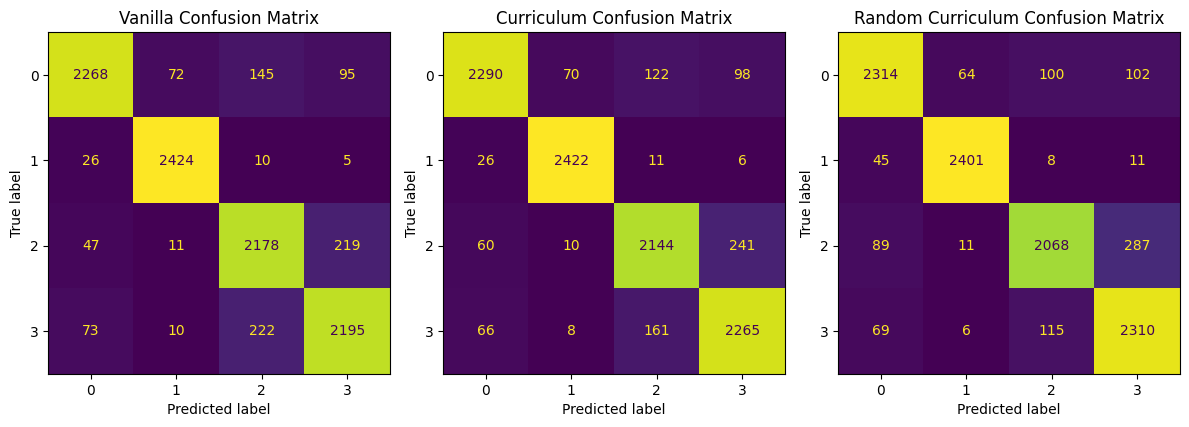

In [63]:
# ----------- Per-Bucket Evaluation -----------
for name, (Xb, yb) in [("easy", (X_easy, y_easy)), ("medium", (X_medium, y_medium)), ("hard", (X_hard, y_hard))]:
    acc_v = evaluate(vanilla_model, Xb, yb)
    acc_c = evaluate(curr_model, Xb, yb)
    acc_r = evaluate(random_model, Xb, yb)
    print(f"{name.capitalize()} Bucket - Vanilla: {acc_v:.3f}, Curriculum: {acc_c:.3f}, Random: {acc_r:.3f}")

# ----------- Confusion Matrix -----------
preds_v = predict(vanilla_model, X_test)
preds_c = predict(curr_model, X_test)
cm_v = confusion_matrix(y_test, preds_v)
cm_c = confusion_matrix(y_test, preds_c)

preds_r = predict(random_model, X_test)
cm_r = confusion_matrix(y_test, preds_r)

fig, axs = plt.subplots(1, 3, figsize=(12, 5))
ConfusionMatrixDisplay(cm_v).plot(ax=axs[0], colorbar=False)
axs[0].set_title("Vanilla Confusion Matrix")
ConfusionMatrixDisplay(cm_c).plot(ax=axs[1], colorbar=False)
axs[1].set_title("Curriculum Confusion Matrix")
ConfusionMatrixDisplay(cm_r).plot(ax=axs[2], colorbar=False)
axs[2].set_title("Random Curriculum Confusion Matrix")
plt.tight_layout()
plt.show()

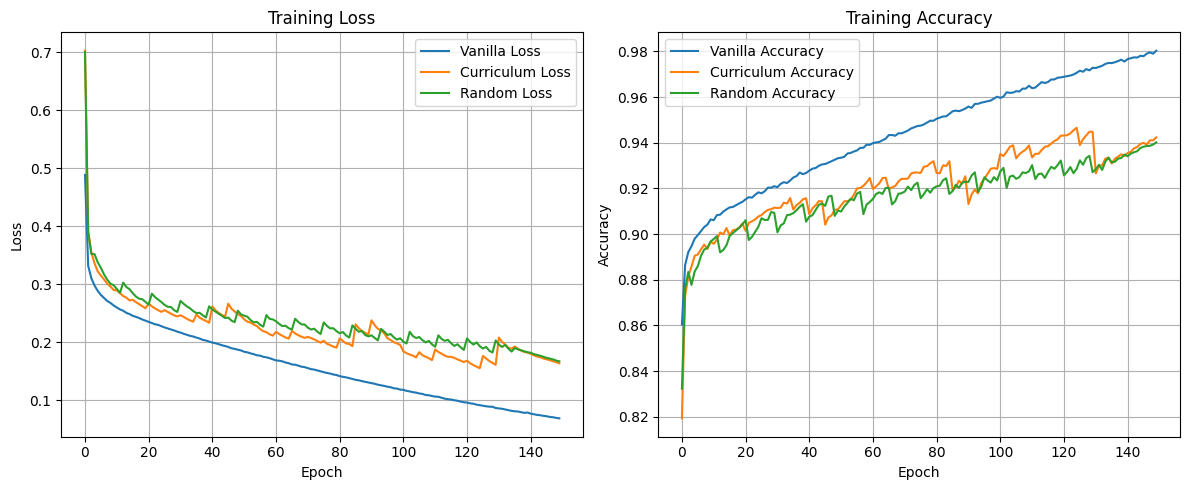

In [64]:
# ----------- Plotting Loss & Accuracy -----------
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(v_loss, label="Vanilla Loss")
plt.plot(c_loss, label="Curriculum Loss")
plt.plot(r_loss, label="Random Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(v_acc, label="Vanilla Accuracy")
plt.plot(c_acc, label="Curriculum Accuracy")
plt.plot(r_acc, label="Random Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("vanilla_vs_curriculum_vs_random_metrics.png")
plt.show()